In [59]:
import sys
sys.path.append("./detection")

In [60]:
import os
import numpy as np
import torch
from PIL import Image
from pathlib import Path
import cv2
from engine import train_one_epoch, evaluate
from data_process import img_showmask
from result_graph import loss_fig, acc_fig
import utils
import torch.utils.data as data
from tqdm.auto import tqdm


class PennFudanDataset(torch.utils.data.Dataset):

    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "image"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "mask"))))
        # self.imgs = list(sorted(os.listdir(os.path.join(root, "ori_image"))))
        # self.masks = list(sorted(os.listdir(os.path.join(root, "ori_mask"))))


    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "image", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask", self.masks[idx])
        # img_path = os.path.join(self.root, "ori_image", self.imgs[idx])
        # mask_path = os.path.join(self.root, "ori_mask", self.masks[idx])
        # print(img_path)
        # img_path = self.imgs[idx]
        # mask_path = self.masks[idx]
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path).convert('L')
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        
        obj_ids = obj_ids[1:]
        # print((obj_ids[:, None, None]).shape)
        # print(obj_ids)
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        
        # print(masks)
        

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1]) + 1.0
            ymin = np.min(pos[0])
            ymax = np.max(pos[0]) + 1.0
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        path = {}
        path["mask_path"] = mask_path
        path["image_path"] = img_path

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target, path

    def __len__(self):
        return len(self.imgs)

In [61]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [62]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [63]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [64]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [65]:
# from engine import train_one_epoch, evaluate
# import utils
# import torch.utils.data as data
# from tqdm.auto import tqdm


In [66]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
# dataset = PennFudanDataset('./data/hubmap-hacking-the-human-vasculature/train', get_transform(train=True))
# data_loader = torch.utils.data.DataLoader(
#  dataset, batch_size=2, shuffle=True, num_workers=0,
#  collate_fn=utils.collate_fn)
# # For Training
# images,targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions

In [67]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations

dataset = PennFudanDataset('./data/hubmap-hacking-the-human-vasculature/train', get_transform(train=False))
dataset_test = PennFudanDataset('./data/hubmap-hacking-the-human-vasculature/train', get_transform(train=False))

train_size=int(len(dataset)*0.9)
validation_size=(len(dataset)-train_size)
print(f"{train_size} {validation_size}")
dataset,dataset_test=data.random_split(dataset, [train_size,validation_size])


# split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

5781 643


In [68]:
# for imgs in data_loader:
#     print(imgs)
#     exit(0)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [0]  [   0/2891]  eta: 0:17:33  lr: 0.000001  loss: 3.9192 (3.9192)  loss_classifier: 0.6684 (0.6684)  loss_box_reg: 0.1089 (0.1089)  loss_mask: 1.5722 (1.5722)  loss_objectness: 1.5022 (1.5022)  loss_rpn_box_reg: 0.0676 (0.0676)  time: 0.3646  data: 0.0592  max mem: 3853
Epoch: [0]  [ 500/2891]  eta: 0:14:47  lr: 0.000150  loss: 1.0520 (1.2596)  loss_classifier: 0.2220 (0.2626)  loss_box_reg: 0.3691 (0.3482)  loss_mask: 0.3206 (0.3997)  loss_objectness: 0.0795 (0.1850)  loss_rpn_box_reg: 0.0320 (0.0641)  time: 0.3792  data: 0.0370  max mem: 4701
Epoch: [0]  [1000/2891]  eta: 0:11:40  lr: 0.000300  loss: 1.0530 (1.1773)  loss_classifier: 0.2470 (0.2521)  loss_box_reg: 0.3675 (0.3589)  loss_mask: 0.3226 (0.3608)  loss_objectness: 0.1038 (0.1440)  loss_rpn_box_reg: 0.0369 (0.0615)  time: 0.3694  data: 0.0366  max mem: 4701
Epoch: [0]  [1500/2891]  eta: 0:08:41  lr: 0.000300  loss: 1.0686 (1.1635)  loss_classifier: 0.2370 (0.2524)  loss_box_reg: 0.3960 (0.3675)  loss_mask: 0.3010 (

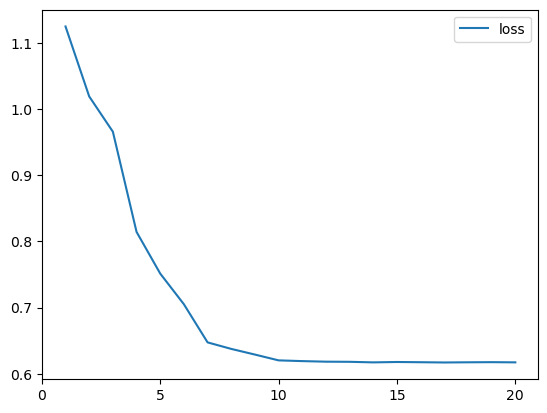

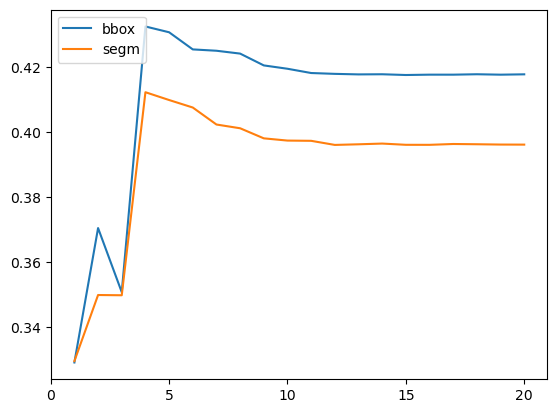

In [69]:
# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=0.0003, weight_decay=1e-6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.01)

# and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,gamma=0.1)

# let's train it for 10 epochs
num_epochs = 20
#  for batch in tqdm(train_loader):
train_loss = []
valid_bbox_acc = []
valid_segm_acc = []
best = 0.0
for epoch in tqdm(range(num_epochs)):
    # train for one epoch, printing every 10 iterations
    train_result = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=500)
    train_loss.append(train_result.meters['loss'].global_avg)
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    valid_result = evaluate(model, data_loader_test, device=device)
    valid_bbox_acc.append(valid_result.coco_eval['bbox'].stats.mean())
    valid_segm_acc.append(valid_result.coco_eval['segm'].stats.mean())
    # valid_loss.append(valid_result.coco_eval['segm'])
    # print(result)
    torch.save(model.state_dict(), f'./model/output_Adam/epoch{epoch}.ckpt')
    if (valid_bbox_acc[-1]+valid_segm_acc[-1])/2 > best:
        torch.save(model.state_dict(), f'./model/best_model.ckpt')
        best = (valid_bbox_acc[-1]+valid_segm_acc[-1])/2
        print(f"epoch{epoch}_best score: {best}")

loss_fig(train_loss , name="./graph/train_Adam")
acc_fig(valid_bbox_acc, valid_segm_acc, name="./graph/valid_Adam")
# [251.5625, 798.4375, 259.375, 798.4375]

In [70]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model_best = get_model_instance_segmentation(num_classes=2).to(device)

# model_best.load_state_dict(torch.load("model/output_Adam/epoch8.ckpt"))
# model_best.eval()
# with torch.no_grad():
#     for img, target, path in tqdm(dataset_test):
#         prediction = model_best([img.to(device)])

#         all_mask = torch.zeros(prediction[0]['masks'][0,0].size())
#         for idx in range(len(prediction[0]['masks'])):
#             score = prediction[0]['scores'][idx].detach().cpu().numpy()
#             if score > 0.5:
#                 all_mask += prediction[0]['masks'][idx][0].cpu()

#         mask = cv2.imread(path["mask_path"])
#         mask = cv2.cvtColor(np.asarray(mask),cv2.COLOR_RGB2BGR) 
#         image = cv2.imread(path["image_path"])
#         img1 = img_showmask(image, mask)
#         cv2.imshow('1',img1)
        
#         image = cv2.imread(path["image_path"])
#         result = Image.fromarray(all_mask.mul(255).byte().cpu().numpy())
#         # result = Image.fromarray(all_mask.mul(255).byte().cpu().numpy())
#         result = cv2.cvtColor(np.asarray(result),cv2.COLOR_RGB2BGR)  
#         img2 = img_showmask(image, result)
#         cv2.imshow('2',img2)
#         cv2.waitKey()